https://discourse.pymc.io/t/gaussian-mixture-of-regression/537

In [1]:
%pylab inline
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import theano.tensor as tt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
sns.set_color_codes()
C0, C1 = sns.color_palette()[:2]

Populating the interactive namespace from numpy and matplotlib


# Display raw data

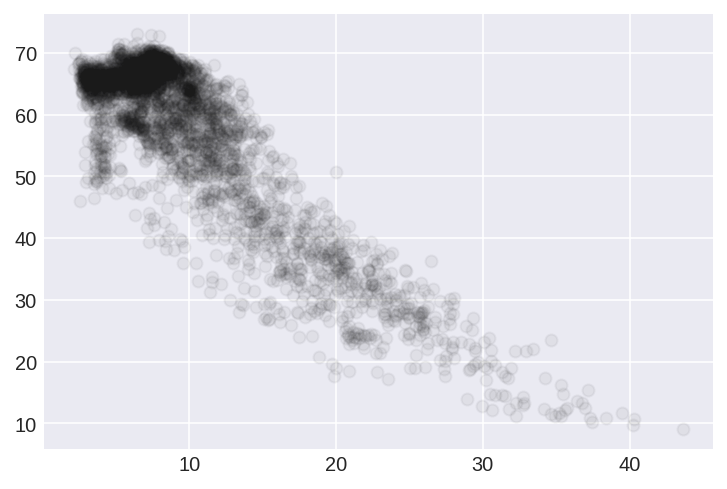

In [2]:
df = pd.read_csv('mixture.csv')
X = df['X'].values
Y = df['Y'].values
plt.scatter(X, Y, alpha=.05, color='k');

In [3]:
Y.shape

(3691,)

# Marginalized mixture

In [3]:
k = 2 
with pm.Model() as gmm1:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
    trace1 = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, β, α, π_stickbreaking__]
100%|██████████| 2000/2000 [00:28<00:00, 71.24it/s]


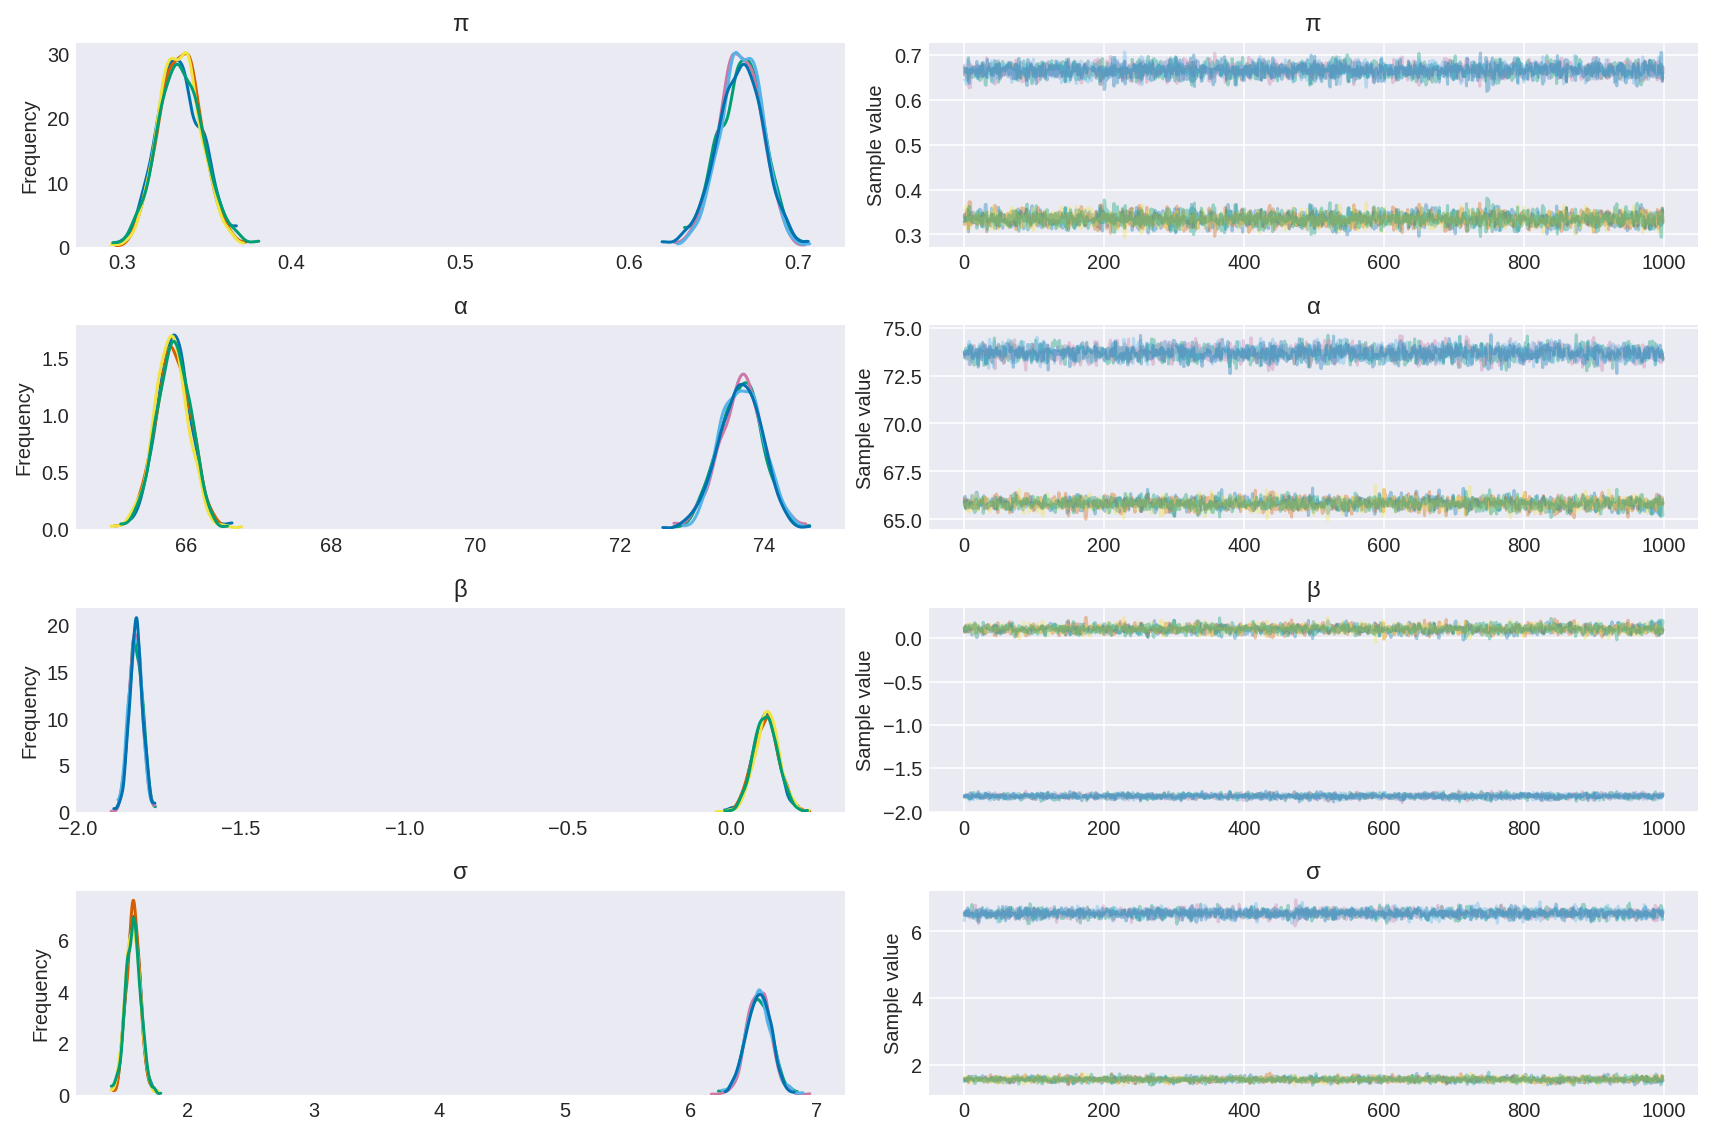

In [4]:
pm.traceplot(trace1, varnames=['π', 'α', 'β', 'σ']);

In [4]:
k = 2 
with pm.Model() as gmm1_:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.Mixture('likelihood', π, pm.Normal.dist(mu=mu, sd=σ), observed=Y)
    trace1_ = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, β, α, π_stickbreaking__]
100%|██████████| 2000/2000 [00:24<00:00, 80.61it/s]


In [6]:
mu.tag.test_value.shape

(3691, 2)

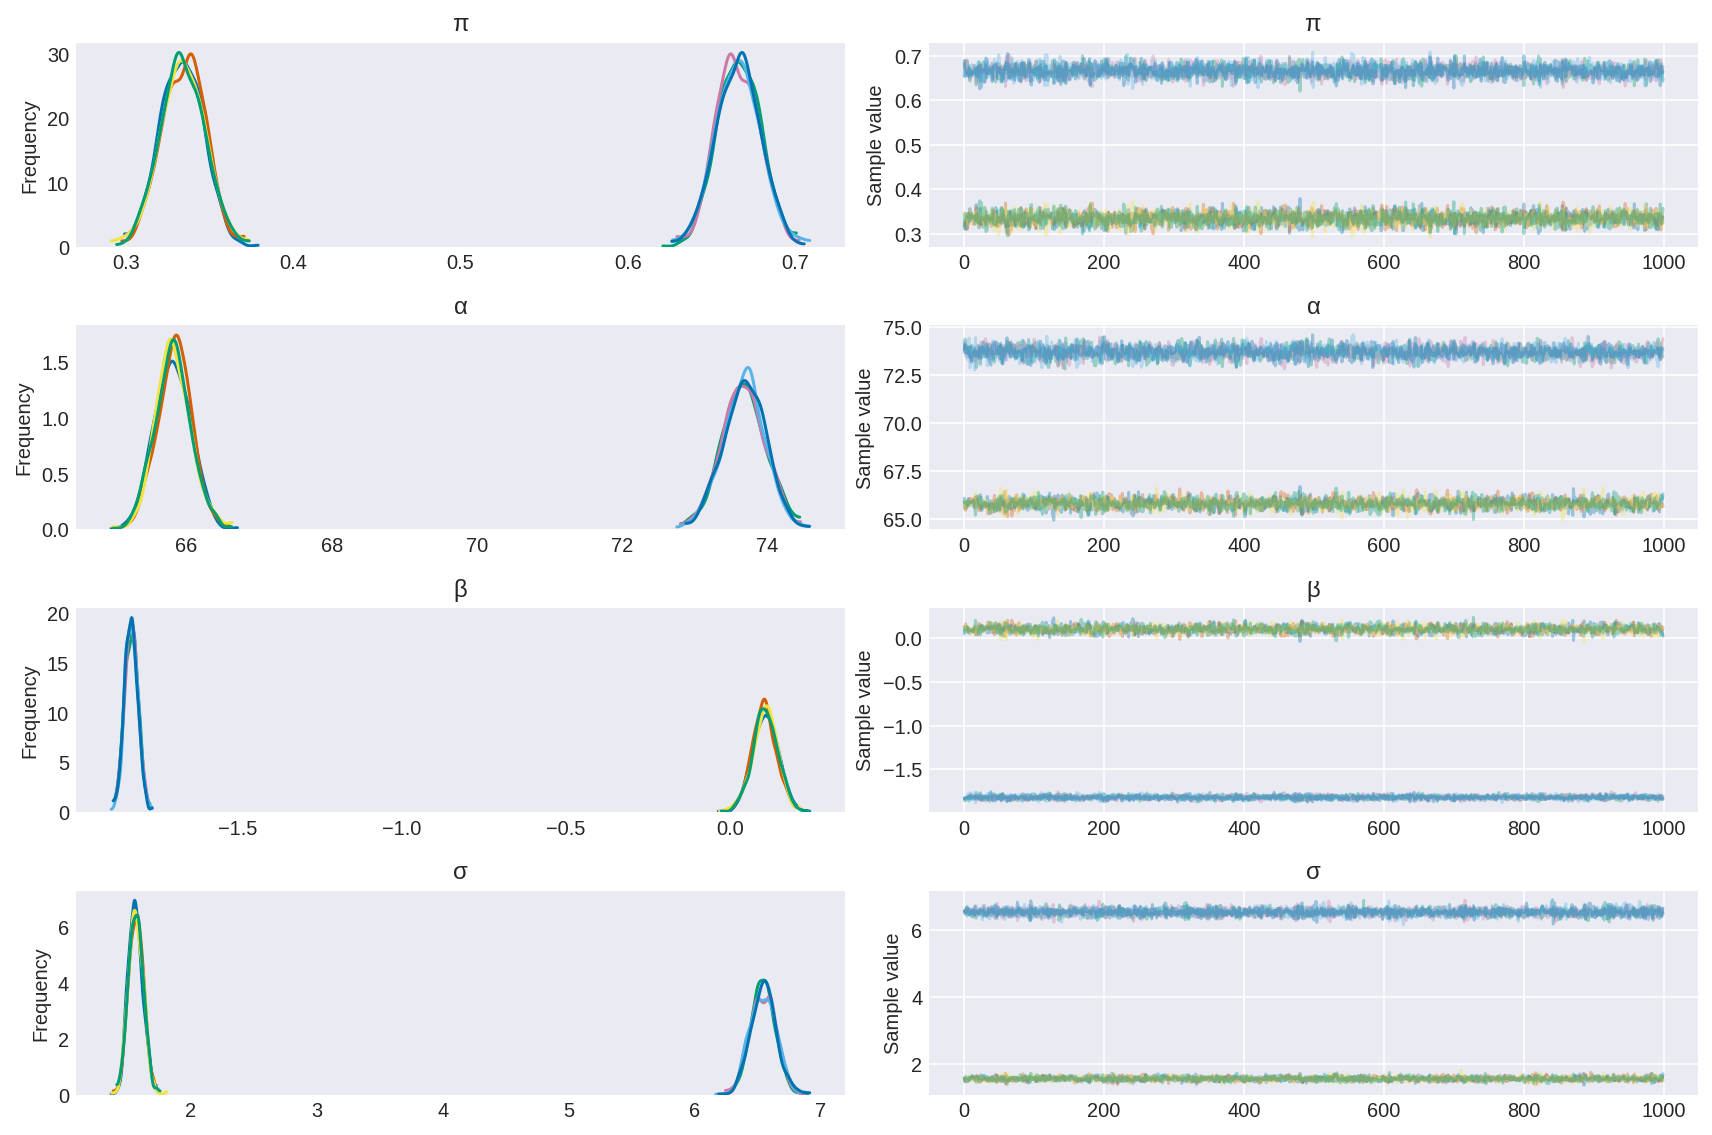

In [5]:
pm.traceplot(trace1_, varnames=['π', 'α', 'β', 'σ']);

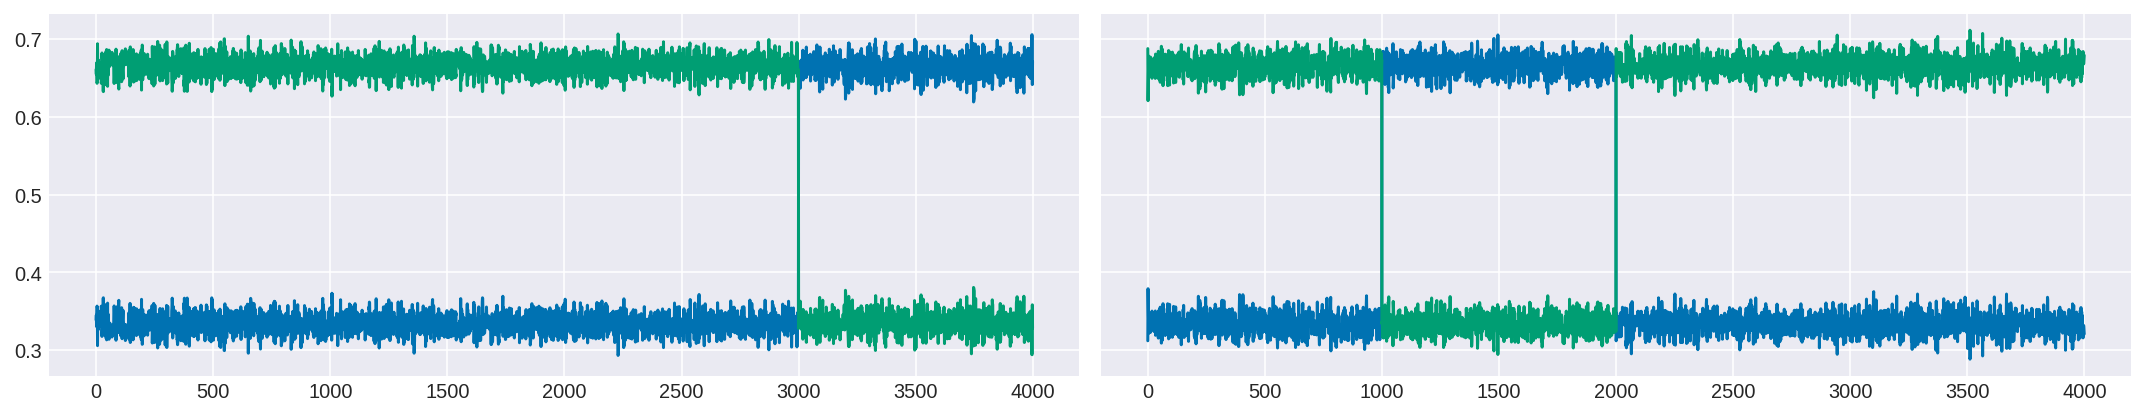

In [7]:
_, ax = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
ax[0].plot(trace1.get_values(varname='π'))
ax[1].plot(trace1_.get_values(varname='π'))
plt.tight_layout();

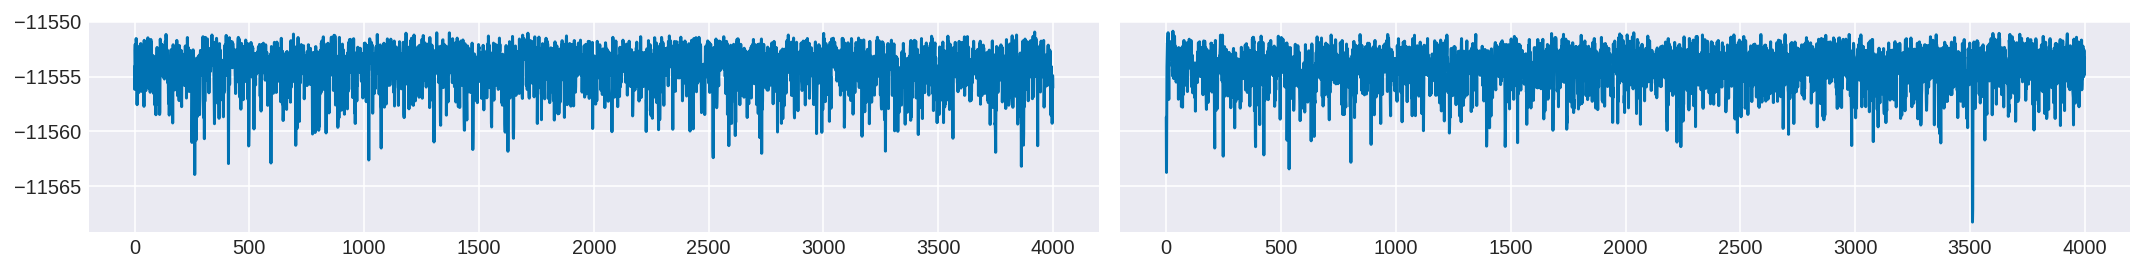

In [8]:
log_py = pm.stats._log_post_trace(trace1, gmm1)
log_py_ = pm.stats._log_post_trace(trace1_, gmm1_)
_, ax = plt.subplots(1, 2, figsize=(15, 2), sharey=True)
ax[0].plot(log_py)
ax[1].plot(log_py_)
plt.tight_layout();

In [14]:
with gmm1:
    advi_old = pm.advi(n=20000)
    tracevi_1 = pm.sample_vp(advi_old, 1000)
    advi_new = pm.fit(20000, method='advi')
    tracevi_2 = advi_new.sample(1000)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  
Average ELBO = -12,828:  92%|█████████▏| 18423/20000 [00:17<00:01, 1064.95it/s]Median ELBO converged.
INFO:pymc3:Median ELBO converged.
Finished [100%]: Average ELBO = -12,779
INFO:pymc3:Finished [100%]: Average ELBO = -12,779

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  This is separate from the ipykernel package so we can avoid doing imports until
Average Loss = 12,606: 100%|██████████| 20000/20000 [00:28<00:00, 710.21it/s]
Finished [100%]: Average Loss = 12,605
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 12,605


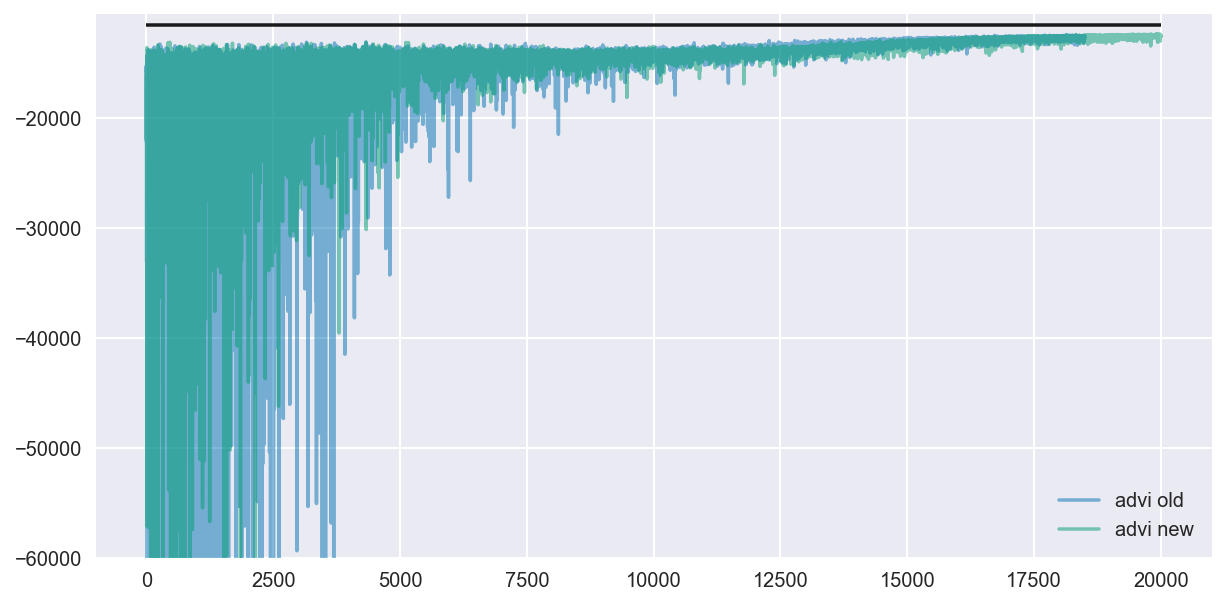

In [35]:
_, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
ax.plot(advi_old.elbo_vals, label='advi old', alpha=.5)
ax.plot(-advi_new.hist, label='advi new', alpha=.5)
ax.hlines(log_py.mean(), xmin=0, xmax=20000)
ax.set_ylim(-60000, log_py.min()+1000)
plt.legend();

In [31]:
ax.hlines?

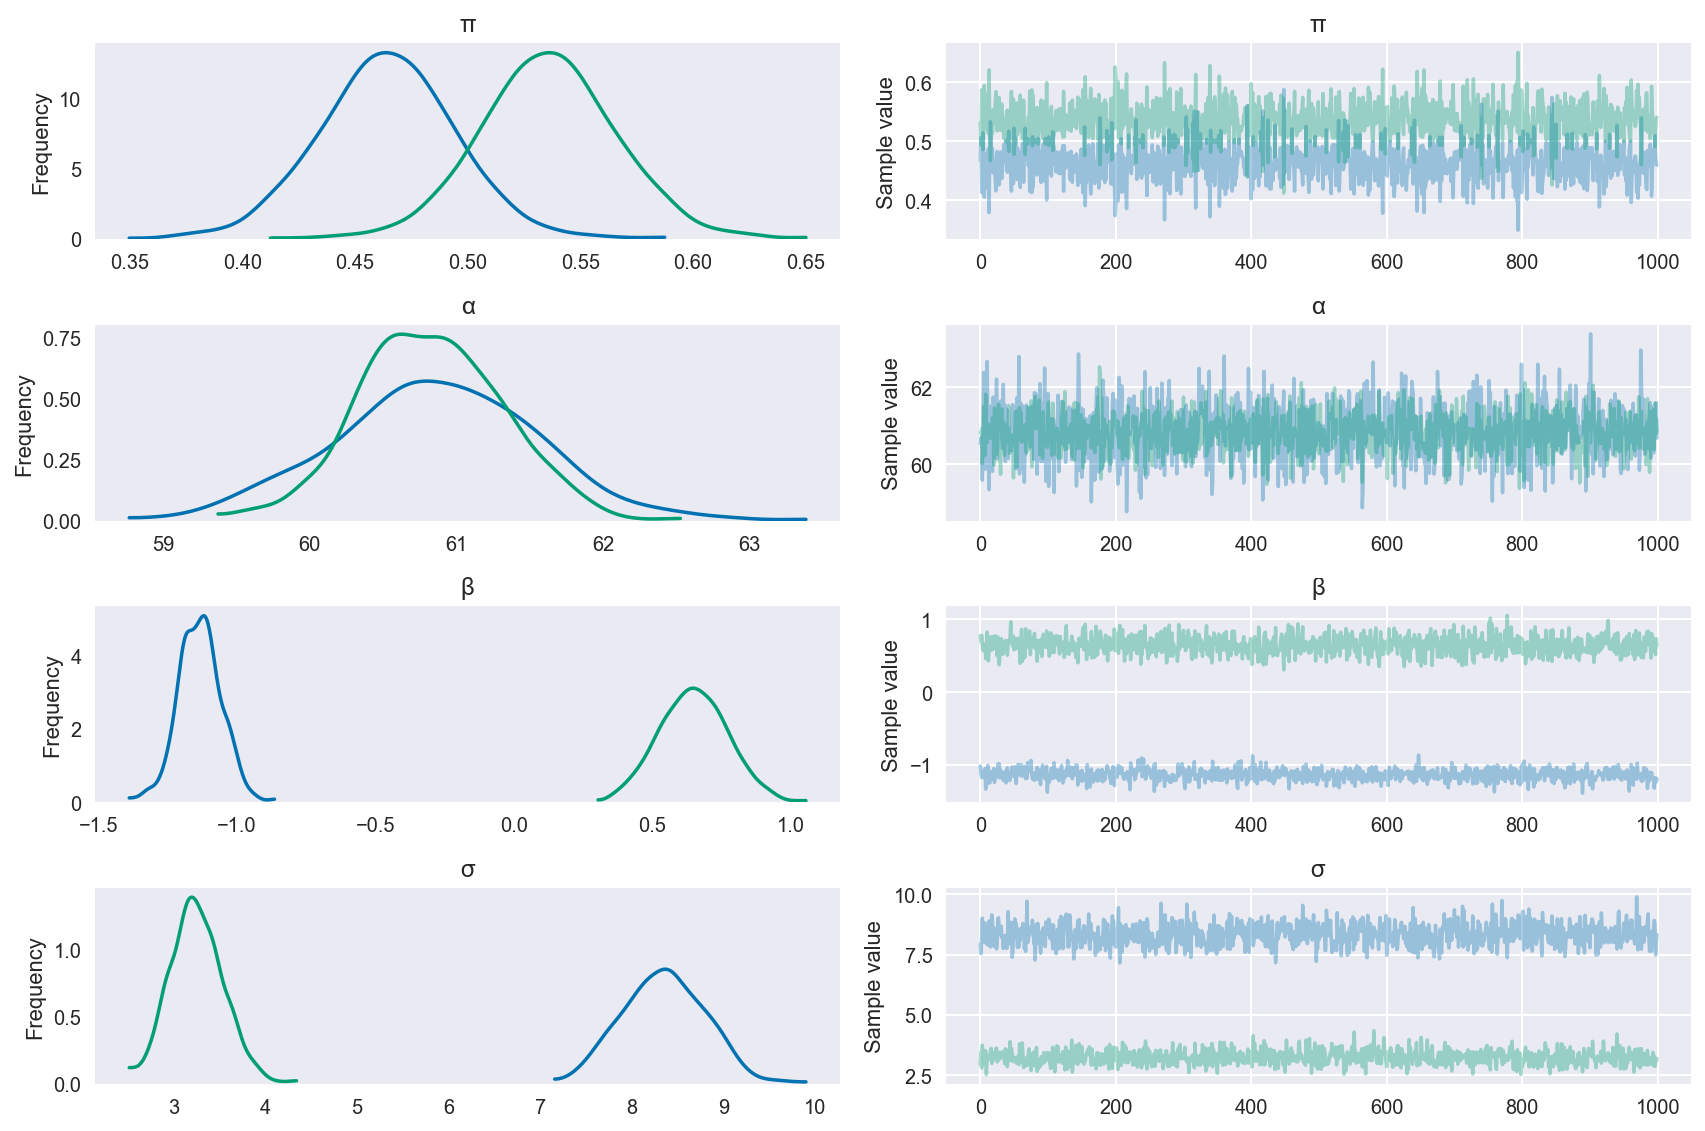

In [15]:
pm.traceplot(tracevi_1, varnames=['π', 'α', 'β', 'σ']);

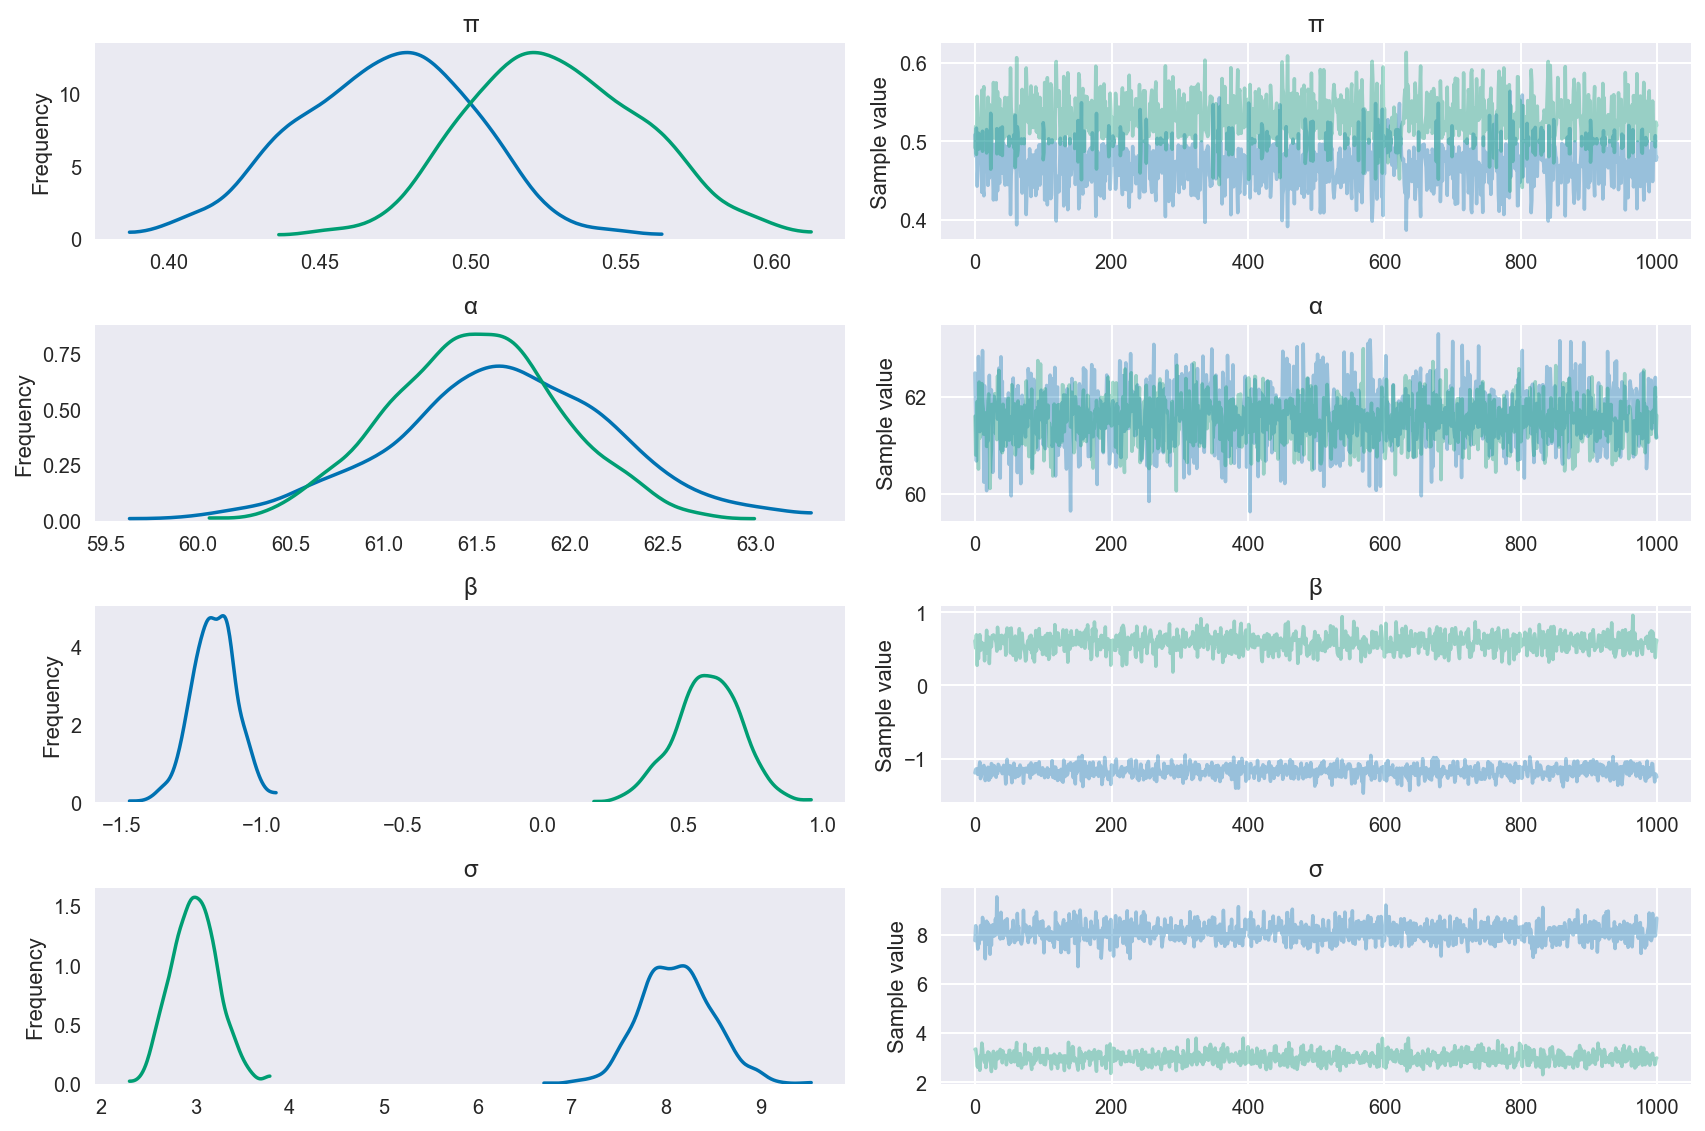

In [16]:
pm.traceplot(tracevi_2, varnames=['π', 'α', 'β', 'σ']);

# with ordered transformation

In [8]:
class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def jacobian_det(self, y):
        return tt.sum(y[1:])


class Composed(pm.distributions.transforms.Transform):    
    def __init__(self, trafo1, trafo2):
        self._trafo1 = trafo1
        self._trafo2 = trafo2
        self.name = '_'.join([trafo1.name, trafo2.name])

    def forward(self, x):
        return self._trafo2.forward(self._trafo1.forward(x))
    
    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._trafo1.backward(self._trafo2.backward(y))

    def jacobian_det(self, y):
        y2 = self._trafo2.backward(y)
        det1 = self._trafo1.jacobian_det(y2)
        det2 = self._trafo2.jacobian_det(y)
        return det1 + det2

In [30]:
with pm.Model() as gmm2:
    trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.asarray([.1, .9]),
                     transform=trafo)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
    trace2 = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
  0%|          | 0/2000 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x102232db0, file "/Lib...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Library/Frameworks/Python.framework/Versions/3....ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Library/Fra.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x102232db0, file "/Lib...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Library/Frameworks/Python.framework/Versions/3....ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Library/Fra.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 9, 20, 56, 55, 782804, tzinfo=tzutc()), 'msg_id': '316D4EDB1A624A63870CBAE1F06EFFA9', 'msg_type': 'execute_request', 'session': '2F526C57BBCF4E6C8D8F81137C509019', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '316D4EDB1A624A63870CBAE1F06EFFA9', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2F526C57BBCF4E6C8D8F81137C509019']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 9, 20, 56, 55, 782804, tzinfo=tzutc()), 'msg_id': '316D4EDB1A624A63870CBAE1F06EFFA9', 'msg_type': 'execute_request', 'session': '2F526C57BBCF4E6C8D8F81137C509019', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '316D4EDB1A624A63870CBAE1F06EFFA9', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2F526C57BBCF4E6C8D8F81137C509019'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 9, 20, 56, 55, 782804, tzinfo=tzutc()), 'msg_id': '316D4EDB1A624A63870CBAE1F06EFFA9', 'msg_type': 'execute_request', 'session': '2F526C57BBCF4E6C8D8F81137C509019', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '316D4EDB1A624A63870CBAE1F06EFFA9', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with pm.Model() as gmm2:\n    trafo = Composed(pm...served=Y)\n    trace2 = pm.sample(1000, tune=1000)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-30-37df0f5f2d05>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1225980b8, execution_..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x112d4fed0, file "<ipython-input-30-37df0f5f2d05>", line 1>
        result = <ExecutionResult object at 1225980b8, execution_..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x112d4fed0, file "<ipython-input-30-37df0f5f2d05>", line 1>, result=<ExecutionResult object at 1225980b8, execution_..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x112d4fed0, file "<ipython-input-30-37df0f5f2d05>", line 1>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'C0': (0.0, 0.4470588235294118, 0.6980392156862745), 'C1': (0.0, 0.6196078431372549, 0.45098039215686275), ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'C0': (0.0, 0.4470588235294118, 0.6980392156862745), 'C1': (0.0, 0.6196078431372549, 0.45098039215686275), ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/jlao/Documents/Github/Human_Learning/Miscellaneous/PyMC3QnA/mixture/<ipython-input-30-37df0f5f2d05> in <module>()
     11     σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
     12     
     13     mu = α + X[:,None]*β
     14         
     15     likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
---> 16     trace2 = pm.sample(1000, tune=1000)

...........................................................................
/Users/jlao/Documents/Github/pymc3/pymc3/sampling.py in sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])}, {'α': array([ 57.47035959,  58.30563   ]), 'β': array([ 0.95319709, -0.13749781]), 'π_logodds_ordered__': array([ 1.94267299,         nan]), 'σ_log__': array([ 2.17902885,  2.35664502])}], trace=None, chain_idx=0, chains=2, njobs=2, tune=1000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[640695538, 311289227], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, **kwargs={})
    381     sample_args.update(kwargs)
    382 
    383     parallel = njobs > 1 and chains > 1
    384     if parallel:
    385         try:
--> 386             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': [640695538, 311289227], 'start': [{'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])}, {'α': array([ 57.47035959,  58.30563   ]), 'β': array([ 0.95319709, -0.13749781]), 'π_logodds_ordered__': array([ 1.94267299,         nan]), 'σ_log__': array([ 2.17902885,  2.35664502])}], ...}
    387         except pickle.PickleError:
    388             pm._log.warn("Could not pickle model, sampling sequentially.")
    389             pm._log.debug('Pickling error:', exec_info=True)
    390             parallel = False

...........................................................................
/Users/jlao/Documents/Github/pymc3/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})
    610 
    611     chain_nums = list(range(chain, chain + chains))
    612     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    613     jobs = (delayed(_sample)(*args, **kwargs)
    614             for args in zip(chain_nums, pbars, rseed, start))
--> 615     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 2
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    616     return MultiTrace(traces)
    617 
    618 
    619 def stop_tuning(step):

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Nov  9 21:57:01 2017
PID: 4664Python 3.5.1: /Library/Frameworks/Python.framework/Versions/3.5/bin/python3.5
...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 640695538, {'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])}), {'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 640695538, {'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])})
        kwargs = {'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/jlao/Documents/Github/pymc3/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=640695538, start={'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])}, draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=1000, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    458                             tune, model, random_seed)
    459     if progressbar:
    460         sampling = tqdm(sampling, total=draws)
    461     try:
    462         strace = None
--> 463         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/2000 [00:00<?, ?it/s]
    464             if live_plot:
    465                 if live_plot_kwargs is None:
    466                     live_plot_kwargs = {}
    467                 if it >= skip_first:

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/2000 [00:00<?, ?it/s])
    857             except AttributeError:
    858                 raise TqdmDeprecationWarning("""\
    859 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    860 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    861 
--> 862             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    863                 yield obj
    864                 # Update and print the progressbar.
    865                 # Note: does not call self.update(1) for speed optimisation.
    866                 n += 1

...........................................................................
/Users/jlao/Documents/Github/pymc3/pymc3/sampling.py in _iter_sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])}, trace=None, chain=0, tune=1000, model=<pymc3.model.Model object>, random_seed=640695538)
    555     try:
    556         for i in range(draws):
    557             if i == tune:
    558                 step = stop_tuning(step)
    559             if step.generates_stats:
--> 560                 point, states = step.step(point)
        point = {'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    561                 if strace.supports_sampler_stats:
    562                     strace.record(point, states)
    563                 else:
    564                     strace.record(point)

...........................................................................
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'α': array([ 58.60820038,  57.20360518]), 'β': array([-0.60395732,  0.38578659]), 'π_logodds_ordered__': array([ 1.57503989,         nan]), 'σ_log__': array([ 1.13773674,  1.76391111])})
    178     def step(self, point):
    179         self._logp_dlogp_func.set_extra_values(point)
    180         array = self._logp_dlogp_func.dict_to_array(point)
    181 
    182         if self.generates_stats:
--> 183             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method NUTS.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([  1.13773674,   1.76391111,  -0.60395732,...20038,  57.20360518,   1.57503989,          nan])
    184             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    185             return point, stats
    186         else:
    187             apoint = self.astep(array)

...........................................................................
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([  1.13773674,   1.76391111,  -0.60395732,...20038,  57.20360518,   1.57503989,          nan]))
    177         p0 = self.potential.random()
    178         start = self.integrator.compute_state(q0, p0)
    179 
    180         if not np.isfinite(start.energy):
    181             raise ValueError('Bad initial energy: %s. The model '
--> 182                              'might be misspecified.' % start.energy)
        start.energy = nan
    183 
    184         if not self.adapt_step_size:
    185             step_size = self.step_size
    186         elif self.tune:

ValueError: Bad initial energy: nan. The model might be misspecified.
___________________________________________________________________________

In [20]:
with pm.Model() as gmm2:
    # Priors for weight parameter
    π_ = pm.Dirichlet('π_', np.array([1]*k), testval=np.ones(k)/k)
    π = pm.Deterministic('π', tt.sort(π_))
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
    trace2 = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [01:33<00:00, 21.45it/s]


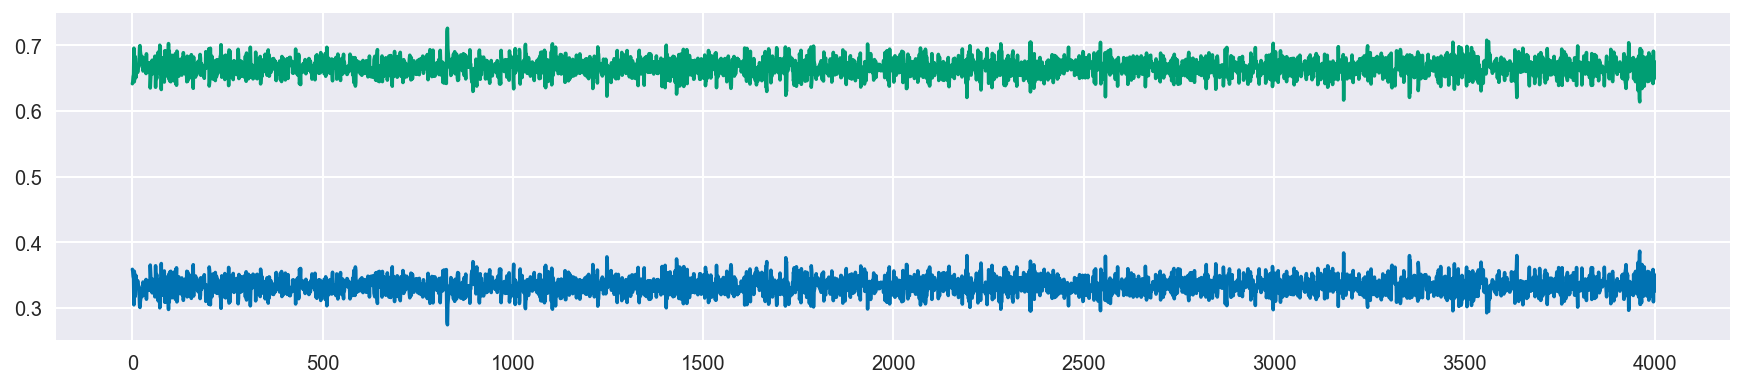

In [21]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.plot(trace2.get_values(varname='π'));

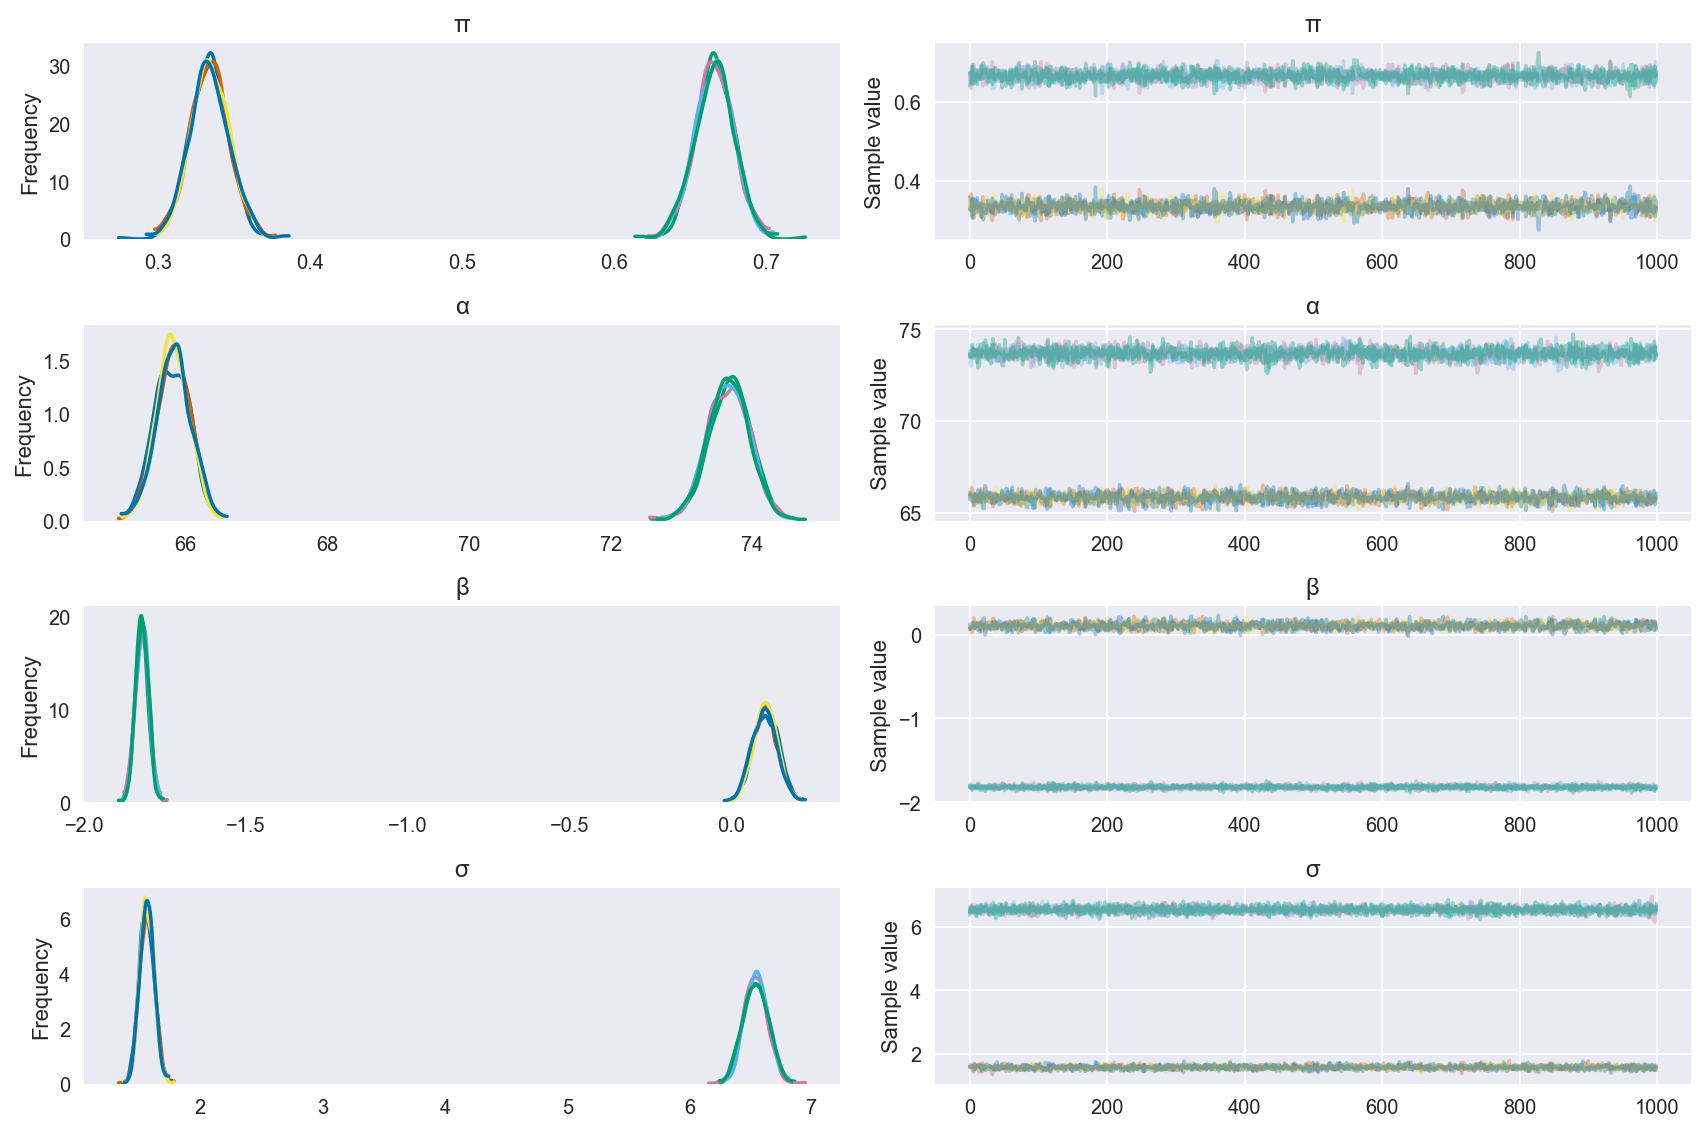

In [22]:
pm.traceplot(trace2, varnames=['π', 'α', 'β', 'σ']);

In [23]:
pm.summary(trace2, varnames=['π', 'α', 'β', 'σ']).round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5   n_eff  Rhat
π__0   0.33  0.01      0.00     0.31      0.36  2747.0   1.0
π__1   0.67  0.01      0.00     0.64      0.69  2747.0   1.0
α__0  65.82  0.24      0.00    65.35     66.28  2291.0   1.0
α__1  73.67  0.29      0.01    73.11     74.25  2275.0   1.0
β__0   0.11  0.04      0.00     0.03      0.18  2240.0   1.0
β__1  -1.82  0.02      0.00    -1.86     -1.78  2370.0   1.0
σ__0   1.56  0.06      0.00     1.46      1.68  2670.0   1.0
σ__1   6.54  0.10      0.00     6.35      6.73  4000.0   1.0

In [31]:
with pm.Model() as gmm2:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()-1, Y.mean()+1]),
                  transform=Ordered()) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
    trace2 = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [01:49<00:00, 24.68it/s]


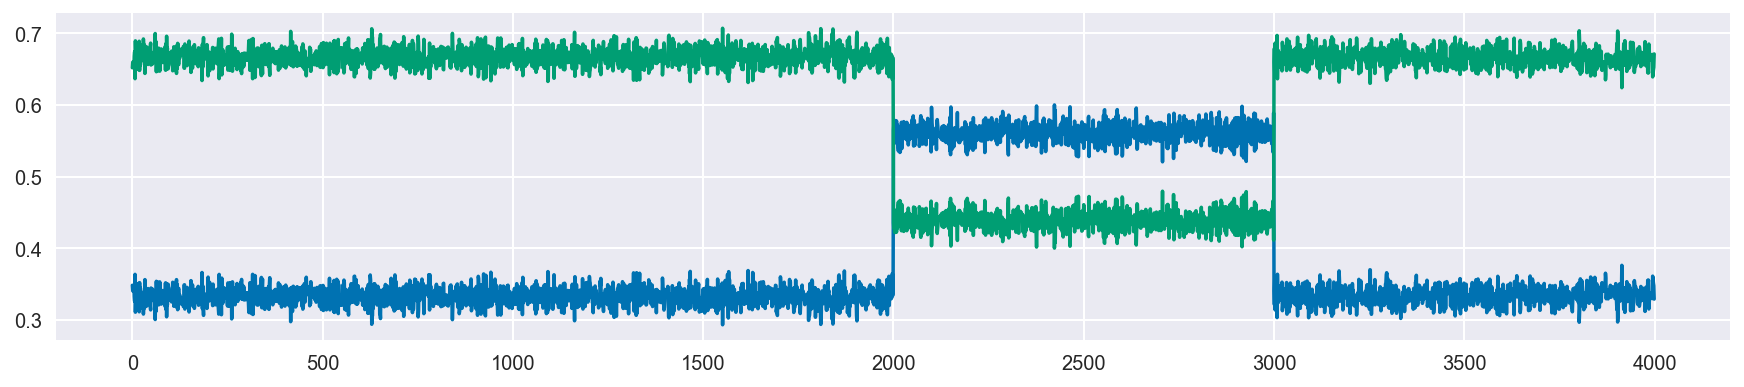

In [32]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.plot(trace2.get_values(varname='π'));

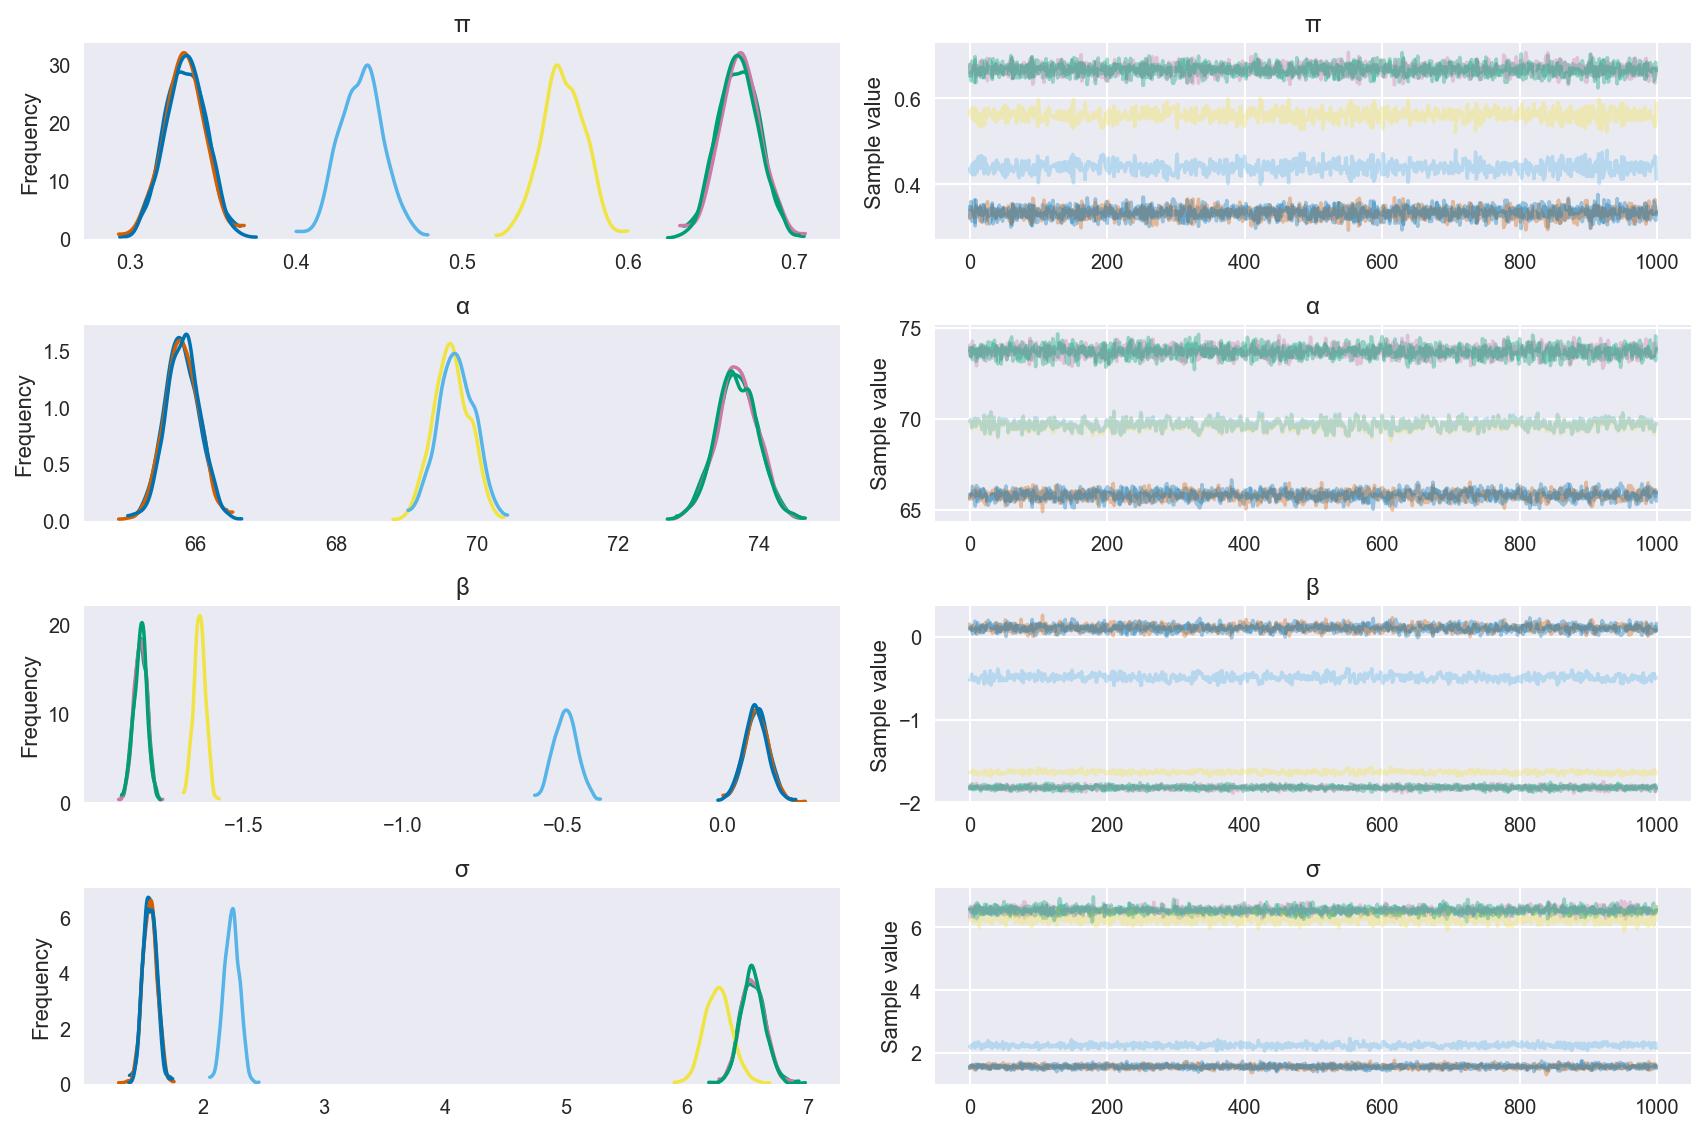

In [33]:
pm.traceplot(trace2, varnames=['π', 'α', 'β', 'σ']);

In [34]:
pm.summary(trace2, varnames=['π', 'α', 'β', 'σ']).round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5  n_eff   Rhat
π__0   0.39  0.10      0.01     0.31      0.58    2.0   9.08
π__1   0.61  0.10      0.01     0.42      0.69    2.0   9.08
α__0  66.76  1.67      0.17    65.36     69.96    2.0   7.88
α__1  72.69  1.75      0.17    69.39     74.23    2.0   7.05
β__0  -0.33  0.76      0.08    -1.67      0.17    2.0  25.60
β__1  -1.49  0.58      0.06    -1.87     -0.45    2.0  25.99
σ__0   2.74  2.03      0.20     1.44      6.36    2.0  31.63
σ__1   5.47  1.87      0.19     2.15      6.72    2.0  23.41

In [16]:
with pm.Model() as gmm2:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α_ = pm.Normal('α_', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    α = pm.Deterministic('α', tt.sort(α_))
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
    trace2 = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [05:10<00:00,  6.45it/s]


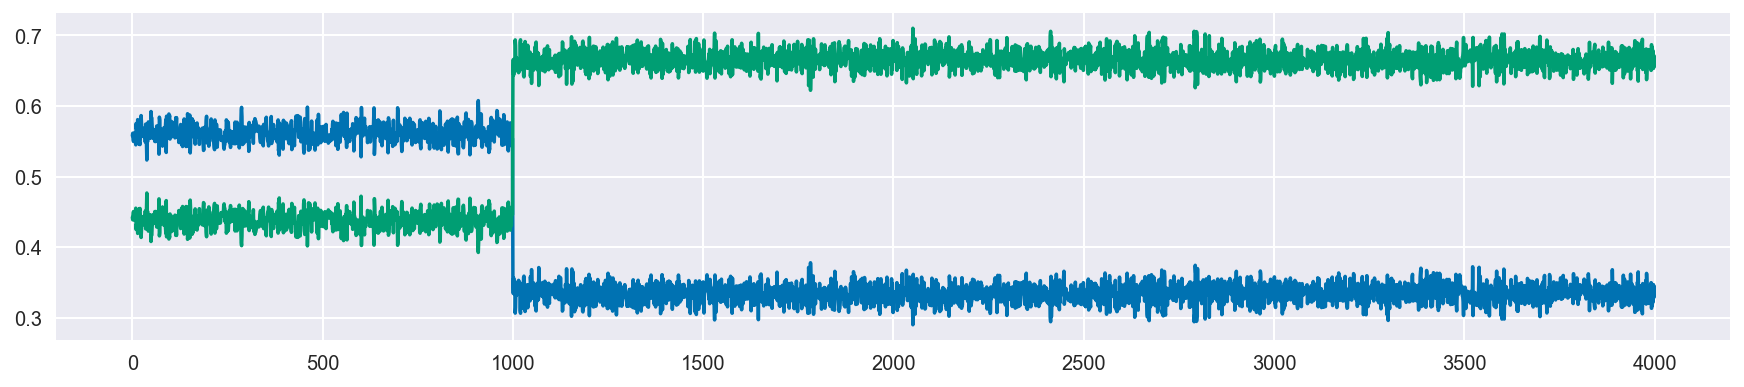

In [17]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.plot(trace2.get_values(varname='π'));

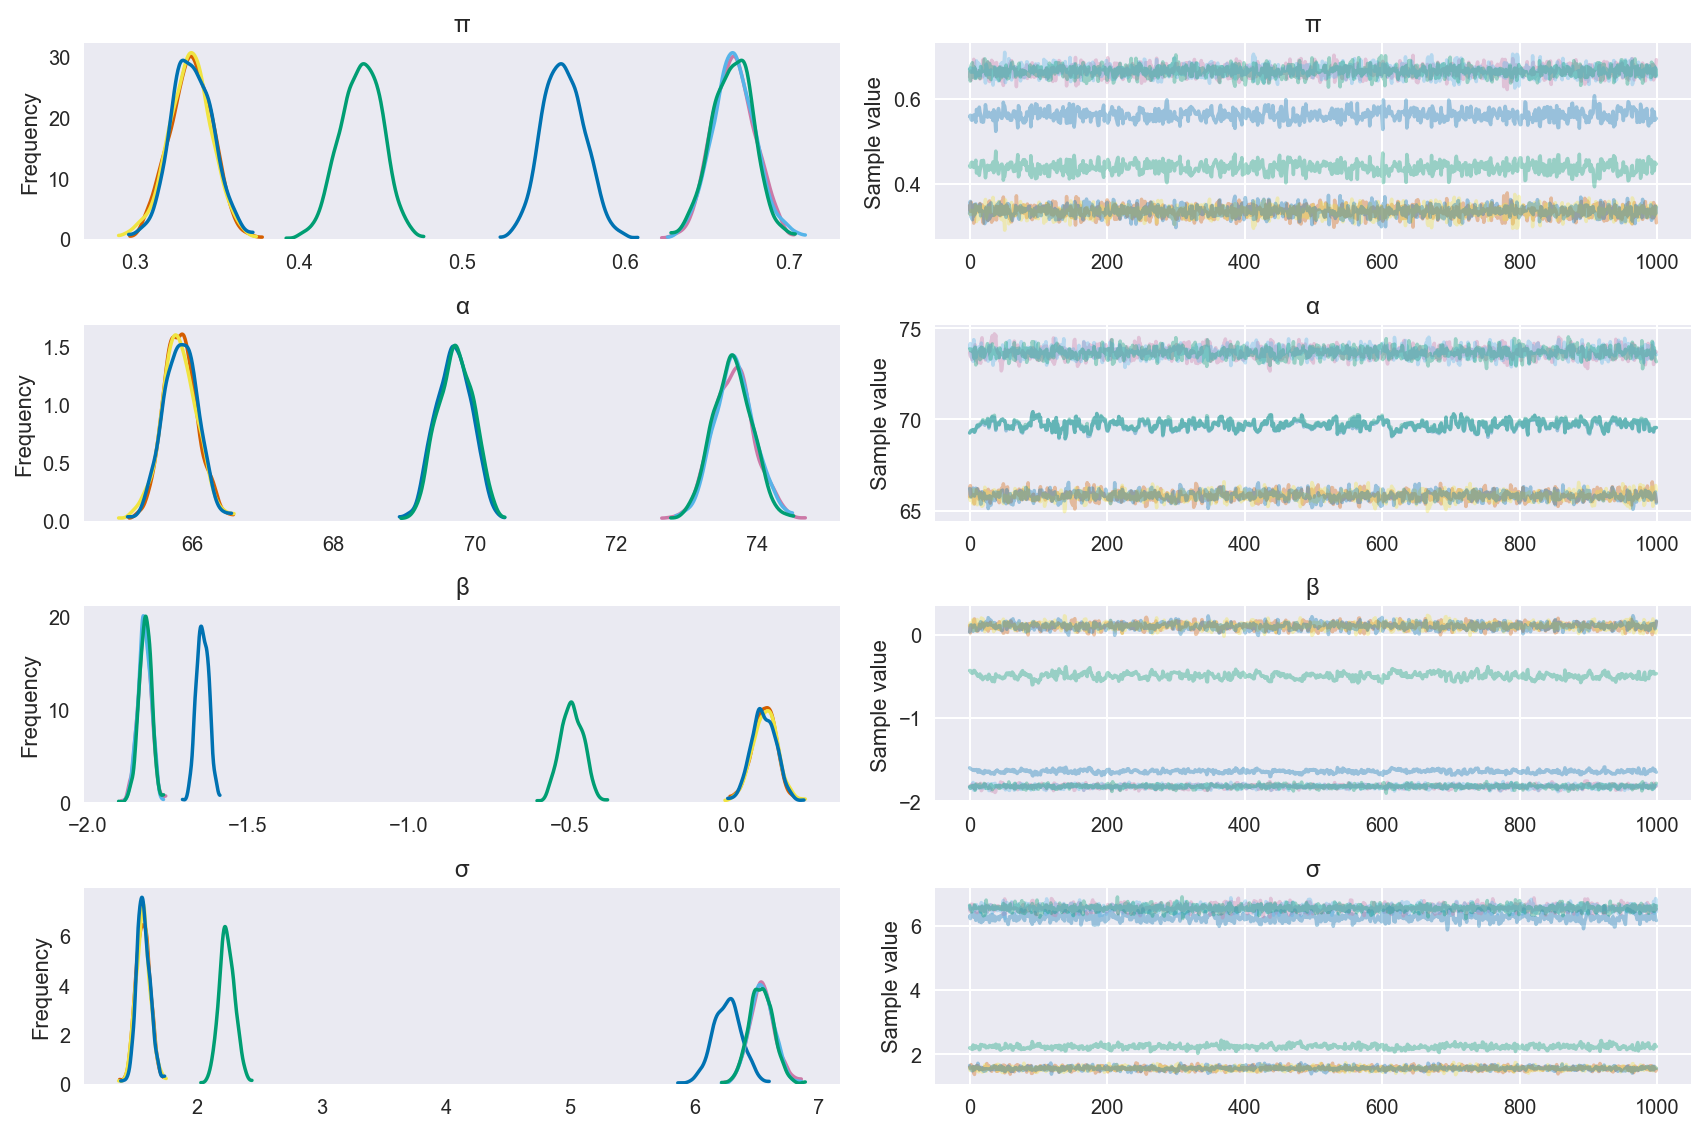

In [18]:
pm.traceplot(trace2, varnames=['π', 'α', 'β', 'σ']);